Using device: cuda:0
Total number of parameters: 2663489
Epoch  1: Train Loss = 2.3593, Val Loss = 2.2606, Val Accuracy = 0.3410, Train Time: 55.5587 seconds, Validation Time: 4.9311 seconds
Epoch  2: Train Loss = 2.0521, Val Loss = 2.1082, Val Accuracy = 0.3954, Train Time: 54.3947 seconds, Validation Time: 4.8757 seconds
Epoch  3: Train Loss = 1.9314, Val Loss = 1.9011, Val Accuracy = 0.4271, Train Time: 54.0550 seconds, Validation Time: 4.8500 seconds
Epoch  4: Train Loss = 1.8555, Val Loss = 1.9355, Val Accuracy = 0.4321, Train Time: 54.1174 seconds, Validation Time: 4.8861 seconds
Epoch  5: Train Loss = 1.8002, Val Loss = 1.9131, Val Accuracy = 0.4461, Train Time: 54.1218 seconds, Validation Time: 4.8798 seconds
Epoch  6: Train Loss = 1.7588, Val Loss = 1.7390, Val Accuracy = 0.4728, Train Time: 54.1899 seconds, Validation Time: 4.8618 seconds
Epoch  7: Train Loss = 1.7246, Val Loss = 1.6910, Val Accuracy = 0.4892, Train Time: 54.2754 seconds, Validation Time: 4.8664 seconds
Epoch

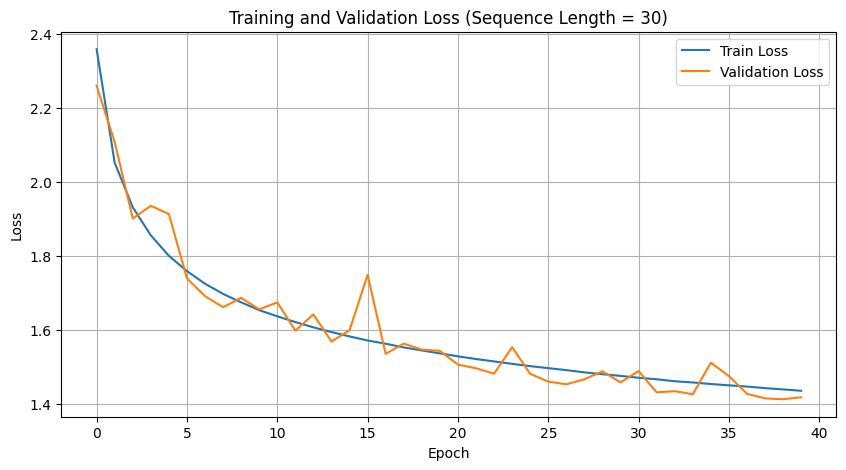

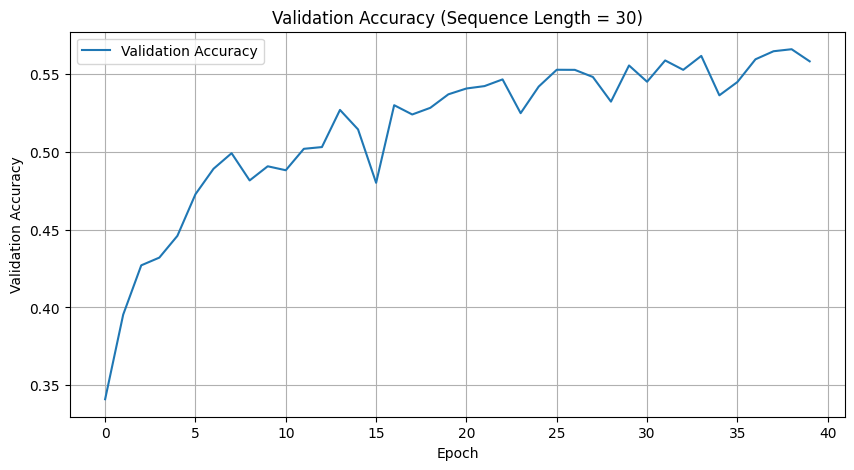

Prediction: After 'To be, or not to b' -> 'l'


In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import requests
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
text = response.text


chars = sorted(list(set(text)))
vocab_size = len(chars)
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}


def create_dataset(text, sequence_length):
    encoded_text = [char_to_int[ch] for ch in text]
    sequences = []
    targets = []
    for i in range(len(encoded_text) - sequence_length):
        seq = encoded_text[i:i+sequence_length]
        target = encoded_text[i+sequence_length]
        sequences.append(seq)
        targets.append(target)
    sequences = torch.tensor(sequences, dtype=torch.long)
    targets = torch.tensor(targets, dtype=torch.long)
    return sequences, targets

class CharDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        return self.sequences[index], self.targets[index]

def get_dataloaders(sequence_length, batch_size=256):
    sequences, targets = create_dataset(text, sequence_length)
    dataset = CharDataset(sequences, targets)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, num_workers=4, pin_memory=True)
    return train_loader, test_loader


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        p = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        p[:, 0::2] = torch.sin(position * div_term)
        p[:, 1::2] = torch.cos(position * div_term)
        p = p.unsqueeze(0)
        self.register_buffer('p', p)

    def forward(self, x):
        return x + self.p[:, :x.size(1)]

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, num_layers=2, nhead=2):
        super(TransformerModel, self).__init__()
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x[:, -1, :]
        output = self.fc(x)
        return output



batch_size = 128
sequence_length = 30
epochs = 40
embed_dim = 256
num_layers = 2
nhead = 2
lr = 0.01

train_loader, test_loader = get_dataloaders(sequence_length, batch_size)


model = TransformerModel(vocab_size, embed_dim, num_layers, nhead).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")


train_losses = []
val_losses = []
val_accuracies = []
start_time = time.time()

total_train_time = 0
total_val_time = 0

for epoch in range(1, epochs+1):
    # Train Time
    epoch_train_start = time.time()
    model.train()
    epoch_train_loss = 0
    for batch_inputs, batch_targets in train_loader:
        batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * batch_inputs.size(0)
    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)
    
    epoch_train_end = time.time()
    train_epoch_time = epoch_train_end - epoch_train_start
    total_train_time += train_epoch_time
    

    epoch_val_start = time.time()
    model.eval()
    epoch_val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_inputs, batch_targets in test_loader:
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_targets)
            epoch_val_loss += loss.item() * batch_inputs.size(0)
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == batch_targets).sum().item()
            total += batch_targets.size(0)
    avg_val_loss = epoch_val_loss / len(test_loader.dataset)
    val_losses.append(avg_val_loss)
    accuracy = correct / total
    val_accuracies.append(accuracy)
    
    epoch_val_end = time.time()
    val_epoch_time = epoch_val_end - epoch_val_start
    total_val_time += val_epoch_time
    
    print(f"Epoch {epoch:2d}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, Val Accuracy = {accuracy:.4f}, Train Time: {train_epoch_time:.4f} seconds, Validation Time: {val_epoch_time:.4f} seconds")

end_time = time.time()
exec_time = end_time - start_time


print(f"\nTraining completed in {exec_time:.2f} seconds")
print(f"Total Train Time: {total_train_time:.2f} seconds")
print(f"Total Validation Time: {total_val_time:.2f} seconds")



plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss (Sequence Length = 30)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy (Sequence Length = 30)")
plt.legend()
plt.grid(True)
plt.show()

def predict_next_char(model, input_str, sequence_length):
    model.eval()
    with torch.no_grad():
        input_str = input_str[-sequence_length:]
        input_tensor = torch.tensor([char_to_int[ch] for ch in input_str], dtype=torch.long).unsqueeze(0).to(device)
        output = model(input_tensor)
        predicted_idx = torch.argmax(output, dim=1).item()
        return int_to_char[predicted_idx]

# Example prediction
test_input = "To be, or not to b"
pred_char = predict_next_char(model, test_input, sequence_length=20)
print(f"Prediction: After '{test_input[-20:]}' -> '{pred_char}'")
